### 01. Normalize File Json (Raw Data)

In [1]:
import json

def normalize_text(text):
    # Replace multiple spaces with a single space
    normalized_text = ' '.join(text.split())
    return normalized_text
    
# Load JSON data from file
with open('project-12-at-2024-05-19-01-47-e8d46c30.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Normalize the text in the JSON data
for item in data:
    if 'data' in item and 'tweet_preprocessed' in item['data']:
        item['data']['tweet_preprocessed'] = normalize_text(item['data']['tweet_preprocessed'])
    if 'annotations' in item:
        for annotation in item['annotations'][0]['result']:
            if 'value' in annotation and 'text' in annotation['value']:
                annotation['value']['text'] = normalize_text(annotation['value']['text'])

# Save the normalized JSON data back to a file
with open('data_normalized.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print("Normalization complete. The normalized file has been saved.")


Normalization complete. The normalized file has been saved.


### 02. Extract JSON to ASTE Format

In [5]:
import json

def getIndex(aspect, indexStart, txt):
    index = []
    counter = 0
    for x in txt[indexStart::-1]:
        if x == " ":
            counter += 1
    index.append(counter)
    if " " in aspect:
        for x in range(0, (aspect.count(" "))):
            index.append(counter + x + 1)
    return index

# Load JSON data from file
with open('data_normalized.json') as f:
    data = json.load(f)

metadata = []
for i in data:
    relationList = []
    sentence = i['data']['tweet_preprocessed']
    for x in i['annotations'][0]['result']:
        if "from_id" in x:
            id_aspect = x["from_id"]
            idOpinion = x["to_id"]
            if x['labels']:
                sent = x['labels'][0]
                relationList.append([id_aspect, idOpinion, sent])
    metadata.append([sentence, relationList])

# Open a file in write mode to save the results
with open('dataset.txt', 'w') as output_file:
    for k in metadata:
        wordlist = []
        for l in k[1]:
            words = []
            for m in l:
                for i in data:
                    for x in i['annotations'][0]['result']:
                        if "value" in x:
                            if x["id"] == m:
                                word = x["value"]["text"]
                                word_start = x["value"]["start"]
                                index = getIndex(word, word_start, k[0])
                                words.append(index)
            words.append(l[2].split(":")[1])
            words = tuple(words)
            wordlist.append(words)
        res = wordlist
        # Write the formatted result to the file
        output_file.write(f"{k[0]} .####{res}\n")


### EDA

num of review data: 1007
num of triplets: 1928
num of POS sentiment: 1195
num of NEU sentiment: 297
num of NEG sentiment: 436


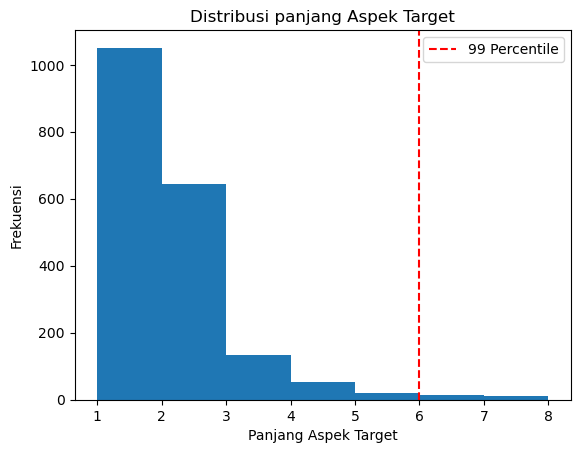

Maximum Aspek Target Length: 8
Minimum Aspek Target Length: 1
Average Aspek Target Length: 1.66597510373444


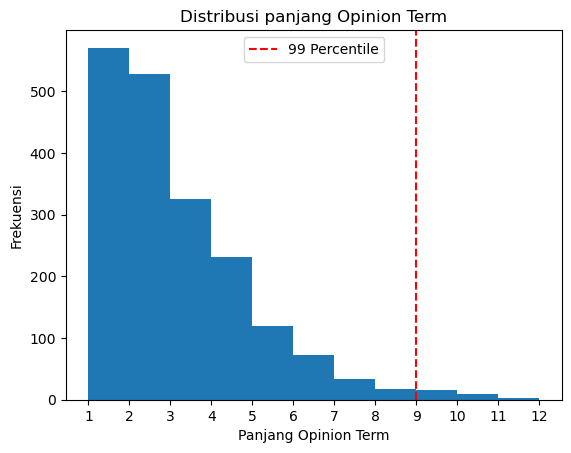

Maximum Opinion Term Length: 12
Minimum Opinion Term Length: 1
Average Opinion Term Length: 2.699688796680498


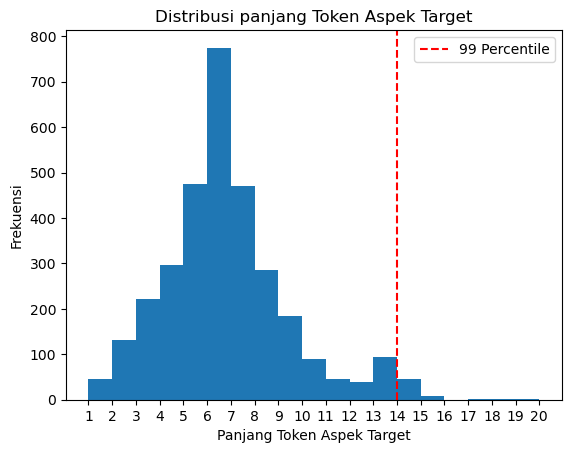

Maximum Token Aspek Target Length: 20
Minimum Token Aspek Target Length: 1
Average Token Aspek Target Length: 6.3365504358655045


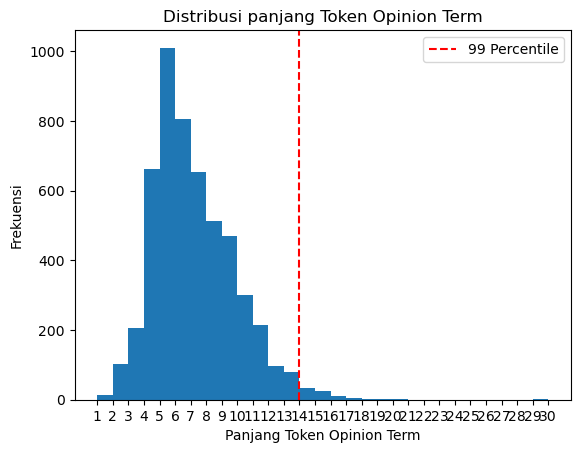

Maximum Token Opinion Term Length: 30
Minimum Token Opinion Term Length: 1
Average Token Opinion Term Length: 6.728914505283381


In [28]:
import ast
import csv
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


freq_triplets = 0
freq_reviews = 0
freq_pos =0
freq_neu = 0
freq_neg = 0
aspects_list=[]
opinion_list=[]
aspects_tokens=[]
opinion_tokens=[]
with open('dataset.txt') as topo_file:
    aspects =[]
    for index,line in enumerate(topo_file):
        freq_reviews+=1
        tagging_info = line.split("####")
        tagging = tagging_info[1]
        sentence = tagging_info[0]
        sentence_split = sentence.split(" ")
        res = ast.literal_eval(tagging)
        # print(res)
        for i,x in enumerate(res):
            sentiment = x[2]
            freq_triplets+=1
            aspect_index = x[0]
            opinion_index = x[1]
            aspects_list.append(aspect_index)
            opinion_list.append(opinion_index)

            aspect = sentence_split[(aspect_index[0]):(aspect_index[-1]) + 1]
            for targets in aspect:
              aspects_tokens.append(targets)

            opinion = sentence_split[(opinion_index[0]):(opinion_index[-1]) + 1]
            for opinions in opinion:
              opinion_tokens.append(opinions)

            if(sentiment == 'POS'):
              freq_pos+=1
            elif(sentiment == 'NEU'):
              freq_neu+=1
            else:
              freq_neg+=1

print(f"num of review data: {freq_reviews}")
print(f"num of triplets: {freq_triplets}")
print(f"num of POS sentiment: {freq_pos}")
print(f"num of NEU sentiment: {freq_neu}")
print(f"num of NEG sentiment: {freq_neg}")

aspects_length = [len(x) for x in aspects_list]
opinion_length = [len(x) for x in opinion_list]
# aspects_tokens = list(set(aspects_tokens))
# opinion_tokens = list(set(opinion_tokens))
aspects_tokens_length = [len(x) for x in aspects_tokens]
opinion_tokens_length = [len(x) for x in opinion_tokens]


def visualize_outlier(list,type,percentile):
  # Calculate the average, minimum, and maximum
  average = sum(list) / len(list)
  minimum = min(list)
  maximum = max(list)

  # Calculate upper maximum value (outlier)
  outlier = np.percentile(list, percentile)  # Adjust the percentile value as desired

  # Plotting the histogram
  plt.hist(list, bins=range(min(list), max(list) + 1))
  plt.xlabel(f'Panjang {type}')
  plt.ylabel('Frekuensi')
  plt.title(f'Distribusi panjang {type}')

  # Adding a line for the upper maximum
  plt.axvline(x=outlier, color='r', linestyle='--', label=f'{percentile} Percentile')

  plt.legend()
  plt.xticks(range(min(list), max(list) + 1))  # Set x-axis tick locations explicitly
  plt.show()
  print(f"Maximum {type} Length: {maximum}")
  print(f"Minimum {type} Length: {minimum}")
  print(f"Average {type} Length: {average}")

visualize_outlier(aspects_length,"Aspek Target",99)
visualize_outlier(opinion_length,"Opinion Term",99)
visualize_outlier(aspects_tokens_length,"Token Aspek Target",99)
visualize_outlier(opinion_tokens_length,"Token Opinion Term",99)

### Cut Outlier

In [21]:
# file_path = "split_sentence.txt"  # Replace with the path to your text file
file_path = "dataset.txt"  # Replace with the path to your text file

import ast
limit_words_aspect = 6
limit_words_opinion = 9
limit_tokens_aspect = 14
limit_tokens_opinion = 14
pos_to_keep = 2000

with open(file_path) as topo_file:
    counter = 0
    final_res = []
    for index, line in enumerate(topo_file):
        outlier = False
        txt_data = line.split("####")
        tagging = txt_data[1]
        res = ast.literal_eval(tagging)
        final_tagged = []
        sentence = txt_data[0]
        sentence_split = sentence.split(" ")
        # print(txt_data)
        for i, x in enumerate(res):
            opinion_length = len(x[1])
            aspect_length = len(x[0])
            aspect_index = x[0]
            opinion_index = x[1]

            aspect = sentence_split[(aspect_index[0]):(aspect_index[-1]) + 1]

            target_len = 0
            for targets in aspect:
                if(len(targets)>target_len):
                    target_len = len(targets)

            opinion = sentence_split[(opinion_index[0]):(opinion_index[-1]) + 1]
            opinion_len = 0
            for opin in opinion:
                if(len(opin)>opinion_len):
                    opinion_len = len(opin)

            if (opinion_length > limit_words_opinion or aspect_length > limit_words_aspect or target_len > limit_tokens_aspect or opinion_len >limit_tokens_opinion):
                print(f"outlier detected: {line}")
                outlier=True
                counter += 1

            else:
                final_tagged.append(x)

        if len(final_tagged) != 0:
            c = f"{txt_data[0]} .####{final_tagged}"
            if outlier:
                print(c)
            final_res.append(c)
    # print(f"Opinions with more than {limit_words} words: {counter}")

# with open('test filter.txt', 'w') as f:
#     for c in final_res:
#         f.write(c)
#         f.write('\n')
comments_to_keep =[]
total_pos=0
total_neg=0
total_neu=0
for line in final_res:
    sentences = line.strip()
    counter_pos=0
    counter_neg=0
    counter_neu=0
    splitted = sentences.split("####")
    tagged_info = splitted[1]
    tagged_data_list = eval(tagged_info)
    for z in tagged_data_list:
        sen = z[2]
        if sen =="POS":
            counter_pos+=1    
        if sen =="NEU":
            counter_neu+=1
        if sen =="NEG":
            counter_neg+=1 
    

    if counter_neg+counter_neu ==0 and pos_to_keep ==0 :
        continue
    
    if counter_neg+counter_neu ==0:
        pos_to_keep-=1
    comments_to_keep.append(sentences)
    total_pos+=counter_pos
    total_neg+=counter_neg
    total_neu+=counter_neu

print(total_pos,total_neg,total_neu) 
print(f"total lines: {len(comments_to_keep)}")  

with open('ready_to_split.txt', 'w') as f:
    for c in final_res:
        f.write(c)
        f.write('\n')



outlier detected: anies baswedan berjanji akan mempertimbangkan aspirasi masyarakat saat ada pembangunan proyek besar jika nantinya dirinya terpilih sebagai presiden. tonton selengkapnya:####[([0, 1], [4, 5, 6], 'POS'), ([9], [4, 5, 6], 'POS')]

outlier detected: anies baswedan berjanji akan mempertimbangkan aspirasi masyarakat saat ada pembangunan proyek besar jika nantinya dirinya terpilih sebagai presiden. tonton selengkapnya:####[([0, 1], [4, 5, 6], 'POS'), ([9], [4, 5, 6], 'POS')]

outlier detected: petani tembakau memang sangat dibutuhkan untuk perekonomian dalam iht. presiden selanjutnya sebaiknya mensejahterakan petani tembakau. aniesbaswedan ganjarpranowo prabowo####[([0, 1], [3, 4], 'POS'), ([9, 10], [12, 13, 14], 'POS')]

petani tembakau memang sangat dibutuhkan untuk perekonomian dalam iht. presiden selanjutnya sebaiknya mensejahterakan petani tembakau. aniesbaswedan ganjarpranowo prabowo .####[([0, 1], [3, 4], 'POS')]
outlier detected: anies baswedan adalah pemimpin yang m

In [22]:
import csv

# Define the path to the CSV file
input_file = "slang_dictionary - slang_dictionary.csv"

# Create an empty dictionary to store slang words and their meanings
slang = {}

# Read the CSV file and populate the slang dictionary
with open(input_file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header row
    next(reader)
    # Iterate over each row in the CSV file
    for row in reader:
        # Extract slang word and its meaning from the row
        slang_word, meaning = row
        # Add the slang word and its meaning to the dictionary
        slang[slang_word] = meaning

In [24]:
import os


# Function to preprocess a line of text
def preprocess_text(line, slang_dict):
    return ' '.join(slang_dict.get(word, word) for word in line.split())

# File paths
input_file_path = 'ready_to_split.txt'
output_file_path = 'dataset_fix_to_split.txt'

# Read the text file
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Preprocess each line and ensure it ends with a newline character
preprocessed_lines = [preprocess_text(line.strip(), slang) + '\n' for line in lines]

# Write the preprocessed text to a new file
with open(output_file_path, 'w', encoding='utf-8') as file:
    file.writelines(preprocessed_lines)

# Optionally, overwrite the original file
# os.rename(output_file_path, input_file_path)


### Split Data for Dataset

In [29]:
import random

# Set the file paths
input_file = "dataset_fix_to_split.txt"
train_file = "train.dat.apc"
dev_file = "dev.dat.apc"
test_file = "test.dat.apc"

# Set the percentages
train_percent = 0.7
dev_percent = 0.15
test_percent = 0.15

# Read the input file
with open(input_file, "r") as f:
    lines = f.readlines()

# Shuffle the lines
random.shuffle(lines)

# Calculate the number of lines for each set
total_lines = len(lines)
train_lines = int(total_lines * train_percent)
dev_lines = int(total_lines * dev_percent)
test_lines = total_lines - train_lines - dev_lines

# Write the lines to the output files
with open(train_file, "w") as f:
    f.writelines(lines[:train_lines])

with open(dev_file, "w") as f:
    f.writelines(lines[train_lines:train_lines+dev_lines])

with open(test_file, "w") as f:
    f.writelines(lines[train_lines+dev_lines:])